# Naive Bayes Classifier: Feedback analysis #

Using data from the Yelp Reviews dataset, let's build a Naive Bayes classifier to classify the sentiment polarity of restaurant reviews (positive or negative). We will start by exploring the data, and then we'll extract some features to start modeling. We will use unigrams to build and test a classifier. To demonstrate the problem of overfitting, the classifier built based on Yelp Review data will be tested on an additional, unseen dataset (as per Lesson 2.7 Challenge). 

To cross-validate and refine the model further, the classifier will be evaluated using 5 folds. Finally, we'll retest it on the unseen dataset to see how well the cross-validation has improved the classifer.

## Overview of the data ##

The dataset of 1000 rows includes just the review text and a sentiment polarity: 1 = positive, 0 = negative.

In [91]:
##Numpy and pandas
import numpy as np
import pandas as pd

##Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##NLP tools
import nltk
from nltk.corpus import stopwords 

##Modeling
import sklearn
from sklearn.naive_bayes import BernoulliNB

#Bag of words model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

##Cross-validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [92]:
# Grab and process the raw data.
yelp_raw = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/yelp_labelled.txt', delimiter= '\t', header=None, encoding='utf-8')
yelp_raw.columns = ['review', 'sentiment']
yelp_raw.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


This dataset includes two balanced classes, with 500 observations in each, so we do not need to employ any special sampling strategies.

In [93]:
#Check how many datapoints are in each category.
yelp_raw['sentiment'].value_counts()

1    500
0    500
Name: sentiment, dtype: int64

For our first try, let's construct a set of keywords for negative sentiment. 

In [94]:
keywords_neg = ['suck', 'else', 'wait', 'gross', 'bad', 'waste', 'rude', 'never', 'terrible']

for key in keywords_neg:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp_raw[str(key)] = yelp_raw.review.str.contains(
        ' ' + str(key),
        case=False
    )

Let's check how independent these keywords are with a heatmap. The keywords we've chosen are pretty independent, so we're not violating the assumptions of the model. 

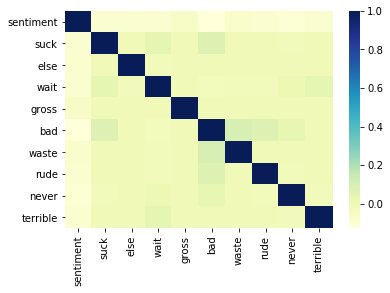

In [95]:
sns.heatmap(yelp_raw.corr(), cmap="YlGnBu")

Next, let's specify the outcome and input variables, and try the model. 

### Iteration 1

In [96]:
data = yelp_raw[keywords_neg]
target = yelp_raw['sentiment']

In [97]:
# Instantiate the Bernoulli model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred1 = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred1).sum()
))



Number of mislabeled points out of a total 1000 points : 417


This initial model fares just a little better than chance, so it needs to be refined. A confusion matrix will narrow in on the model's weakness: sensitivity or specificity. 

In [98]:
from sklearn.metrics import confusion_matrix, f1_score
confusion1 = confusion_matrix(target, y_pred1)
print(confusion1)

type1_error = confusion1[1][0]/(confusion1[1][0]+confusion1[1][1])*100
print(type1_error)

type2_error = confusion1[0][1]/(confusion1[0][0]+confusion1[0][1])*100
print(type2_error)
print (classification_report(target, y_pred1))

[[ 94 406]
 [ 11 489]]
2.2
81.2
             precision    recall  f1-score   support

          0       0.90      0.19      0.31       500
          1       0.55      0.98      0.70       500

avg / total       0.72      0.58      0.51      1000



The model's Type 1 error rate is pretty good: only 11 positive reviews were misclassified as negative reviews (2.2%), while the Type 2 error rate is extremely high: 406 negative reviews were missed (81.2%). Our simple list of 9 negative words was only enough to catch 19% of negative reviews.

### Iteration 2 ###

To refine the model, we'll construct a bag of words model and examine which unigrams occur most frequently in reviews with each sentiment. We'll start by cleaning and tokenizing the reviews (stripping non-alphabetic characters, casting to lowercase, and separating into words). 

The CountVectorizer function from sklearn takes care of tokenization. We could manually remove stopwords, but the term frequency - inverse document frequency (TF-IDF) transformer should have the same effect.

In [99]:
#Start by removing nonalphabetic characters and converting to lowercase.

yelp_token = yelp_raw['review'].str.replace('[^a-zA-Z]', ' ')
yelp_token = yelp_raw['review'].str.lower()

#words = yelp_token.str.split(' ')
#Standardize british vs. am spelling

The Count Vectorizer generates an array where each row is a review from the original dataset, and each column is a word of at least two characters. Each item in the area is a Boolean indicating whether the word is present in that review. Since the highest frequency words contribute little information to the model, we'll transform the dataset so that more informative features are weighted more heavily. 

As we can see from the shape of the array, there are 1000 reviews (the original dataset) and 2034 unigrams.

In [100]:
#Use CountVectorizer to generate an array of unigram counts for each review.
vectorizer = CountVectorizer(stop_words=None, max_features=None)
X = vectorizer.fit(yelp_token)
X = vectorizer.transform(yelp_token)

#Use term frequency - inverse document frequency transformation to weight more informative unigrams.
tfidf_transformer = TfidfTransformer().fit(X)
X_tfidf = tfidf_transformer.transform(X)

#Take a look at the shape of the array.
print(X_tfidf.shape)

(1000, 2034)


Next, we'll refit the model using bag of words instead of the manually constructed list of negative keywords from Iteration 1. This model correctly accounts for 945/1000 datapoints: an accuracy of 94.5%--much better than our first model!

In [101]:
#Refit the model using tfidf in place of the manually constructed keywords list.
bnb.fit(X_tfidf, target)
y_pred2 = bnb.predict(X_tfidf)

#Read out the result.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred2).sum()
))


Number of mislabeled points out of a total 1000 points : 55


Let's evaluate the model using a confusion matrix, to see where it can be improved. The Type 1 and 2 error rates are actually quite similar (5.8% and 5.2%, respectively). This is a much stronger model.

In [102]:
#Evaluate the result in a confusion matrix.
confusion2 = confusion_matrix(target, y_pred2)
print(confusion2)

type1_error = confusion2[1][0]/(confusion2[1][0]+confusion2[1][1])*100
print(type1_error)

type2_error = confusion2[0][1]/(confusion2[0][0]+confusion2[0][1])*100
print(type2_error)

[[474  26]
 [ 29 471]]
5.8
5.2


### The problem!

The bag of words model above is built using the entire dataset, so it suffers from overfitting. The model uses all the data in the yelp reviews corpus, so we expect it to fare well with the yelp review corpus. If we apply it to unseen data, say, the Amazon review corpus, we will not expect the same performance. Let's run through the process, fitting the model to the Amazon data, to demonstrate the problem. 

First, read in the Amazon data, and confirm that it has the same content and shape as the Yelp data.

In [103]:
amazon_raw = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/amazon_cells_labelled.txt', delimiter= '\t', header=None, encoding='utf-8')
amazon_raw.columns = ['review', 'sentiment']
print(amazon_raw['sentiment'].value_counts())
amazon_raw.head()

1    500
0    500
Name: sentiment, dtype: int64


,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [104]:
#Create a variable to store the Amazon target data.

am_token = amazon_raw['review'].str.replace('[^a-zA-Z]', ' ')
am_token = amazon_raw['review'].str.lower()
target_am = amazon_raw['sentiment']

#Transform using the CountVectorizer from the yelp data.
X = vectorizer.transform(am_token)

#Use the model from the yelp data to classify the Amazon data.
y_pred_am = bnb.predict(X)

#Read out the result.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target_am != y_pred_am).sum()
))

#Evaluate the result in a confusion matrix.
confusion_am = confusion_matrix(target_am, y_pred_am)
print(confusion_am)

type1_error = confusion_am[1][0]/(confusion_am[1][0]+confusion_am[1][1])*100
print(type1_error)

type2_error = confusion_am[0][1]/(confusion_am[0][0]+confusion_am[0][1])*100
print(type2_error)
print (classification_report(target_am, y_pred_am))

Number of mislabeled points out of a total 1000 points : 263
[[348 152]
 [111 389]]
22.2
30.4
             precision    recall  f1-score   support

          0       0.76      0.70      0.73       500
          1       0.72      0.78      0.75       500

avg / total       0.74      0.74      0.74      1000



Although the model performed very well on its Yelp training data, when confronted with unseen data, its performance declines markedly. Its Type 1 error rate jumped to 22.2%% and the Type 2 error to 30.4%. This is not surprising: the frequency distributions of words in restaurant reviews are expected to be different from those in general product reviews on Amazon. 

To improve the predictive power of the model, we need to tune it, and cross-validate it using a test dataset. Let's go back to the Yelp dataset, and try again. 

For the purpose of the exercise, we'll focus on the Yelp dataset, which includes context-specific vocabulary that will affect the model's generalizability. If we wanted a classifier that could be deployed across a wider range of contexts, we would need to train and test it on reviews from diverse sources.

### Iteration 3 ###

Let's rerun the model, this time separating it into a training set and a test set. The test set will be 20% of the data (200 of the 1000 reviews).

In [105]:
#Split the data into test and training sets.

X_train, X_test, y_train, y_test = train_test_split(
yelp_token, target, test_size=0.2, random_state=0, shuffle=True)

#Define a pipeline to vectorize, tranfsorm, and classify.
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier',  BernoulliNB()),
    ])

#Train and test the model.
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

#Evaluate the results.
confusion = confusion_matrix(y_test, predictions)

print (classification_report(y_test, predictions))
print(confusion)
type1_error = confusion[1][0]/(confusion[1][0]+confusion[1][1])*100
print(type1_error)

type2_error = confusion[0][1]/(confusion[0][0]+confusion[0][1])*100
print(type2_error)

             precision    recall  f1-score   support

          0       0.76      0.66      0.71        97
          1       0.72      0.81      0.76       103

avg / total       0.74      0.73      0.73       200

[[64 33]
 [20 83]]
19.4174757282
34.0206185567


This initial cross-validation shows that the model's performance is not as good as Iteration 2 would have us believe. We need to take a look inside the model to find out why it is not performing well. 

### Iteration 4###

Let's make our cross-validation more robust using 4 random folds, rather than an 80/20 train/test split, and we'll add a minimum doc frequency parameter to our Count Vectorizer to minimize overfitting due to noise, and a maximum doc frequency parameter to prevent stop words and high-frequency but low semantic load words from affecting the model's performance. 

In [106]:
kf = KFold(n_splits=4, shuffle=True)
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english', min_df=2, max_df=0.8)),
    ('tfidf', TfidfTransformer()),
    ('classifier',  BernoulliNB()),
    ])

for train_index, test_index in kf.split(yelp_token):
    X_train, X_test = yelp_token[train_index], yelp_token[test_index]
    y_train, y_test = target[train_index], target[test_index]
    pipeline.fit(X_train, y_train)
    print(vectorizer.vocabulary_)
    predictions = pipeline.predict(X_test)
    
    #Evaluate the results.
    confusion = confusion_matrix(y_test, predictions)
    print (classification_report(y_test, predictions))
    print(confusion)
    type1_error = confusion[1][0]/(confusion[1][0]+confusion[1][1])*100
    print(type1_error)
    type2_error = confusion[0][1]/(confusion[0][0]+confusion[0][1])*100
    print(type2_error)

{'wow': 2011, 'loved': 1046, 'this': 1797, 'place': 1330, 'crust': 427, 'is': 943, 'not': 1195, 'good': 764, 'tasty': 1760, 'and': 64, 'the': 1779, 'texture': 1773, 'was': 1939, 'just': 967, 'nasty': 1169, 'stopped': 1698, 'by': 264, 'during': 557, 'late': 991, 'may': 1087, 'bank': 139, 'holiday': 867, 'off': 1208, 'rick': 1488, 'steve': 1690, 'recommendation': 1444, 'it': 945, 'selection': 1560, 'on': 1221, 'menu': 1110, 'great': 778, 'so': 1630, 'were': 1964, 'prices': 1374, 'now': 1198, 'am': 57, 'getting': 746, 'angry': 66, 'want': 1933, 'my': 1162, 'damn': 439, 'pho': 1316, 'honeslty': 870, 'didn': 484, 'taste': 1756, 'that': 1777, 'fresh': 713, 'potatoes': 1362, 'like': 1016, 'rubber': 1505, 'you': 2026, 'could': 396, 'tell': 1765, 'they': 1787, 'had': 805, 'been': 167, 'made': 1061, 'up': 1882, 'ahead': 44, 'of': 1207, 'time': 1808, 'being': 173, 'kept': 969, 'under': 1865, 'warmer': 1937, 'fries': 719, 'too': 1823, 'touch': 1832, 'service': 1573, 'very': 1910, 'prompt': 1386, '

[[111  24]
 [ 29  86]]
25.2173913043
17.7777777778
{'wow': 2011, 'loved': 1046, 'this': 1797, 'place': 1330, 'crust': 427, 'is': 943, 'not': 1195, 'good': 764, 'tasty': 1760, 'and': 64, 'the': 1779, 'texture': 1773, 'was': 1939, 'just': 967, 'nasty': 1169, 'stopped': 1698, 'by': 264, 'during': 557, 'late': 991, 'may': 1087, 'bank': 139, 'holiday': 867, 'off': 1208, 'rick': 1488, 'steve': 1690, 'recommendation': 1444, 'it': 945, 'selection': 1560, 'on': 1221, 'menu': 1110, 'great': 778, 'so': 1630, 'were': 1964, 'prices': 1374, 'now': 1198, 'am': 57, 'getting': 746, 'angry': 66, 'want': 1933, 'my': 1162, 'damn': 439, 'pho': 1316, 'honeslty': 870, 'didn': 484, 'taste': 1756, 'that': 1777, 'fresh': 713, 'potatoes': 1362, 'like': 1016, 'rubber': 1505, 'you': 2026, 'could': 396, 'tell': 1765, 'they': 1787, 'had': 805, 'been': 167, 'made': 1061, 'up': 1882, 'ahead': 44, 'of': 1207, 'time': 1808, 'being': 173, 'kept': 969, 'under': 1865, 'warmer': 1937, 'fries': 719, 'too': 1823, 'touch': 183

13.1578947368
33.0882352941
{'wow': 2011, 'loved': 1046, 'this': 1797, 'place': 1330, 'crust': 427, 'is': 943, 'not': 1195, 'good': 764, 'tasty': 1760, 'and': 64, 'the': 1779, 'texture': 1773, 'was': 1939, 'just': 967, 'nasty': 1169, 'stopped': 1698, 'by': 264, 'during': 557, 'late': 991, 'may': 1087, 'bank': 139, 'holiday': 867, 'off': 1208, 'rick': 1488, 'steve': 1690, 'recommendation': 1444, 'it': 945, 'selection': 1560, 'on': 1221, 'menu': 1110, 'great': 778, 'so': 1630, 'were': 1964, 'prices': 1374, 'now': 1198, 'am': 57, 'getting': 746, 'angry': 66, 'want': 1933, 'my': 1162, 'damn': 439, 'pho': 1316, 'honeslty': 870, 'didn': 484, 'taste': 1756, 'that': 1777, 'fresh': 713, 'potatoes': 1362, 'like': 1016, 'rubber': 1505, 'you': 2026, 'could': 396, 'tell': 1765, 'they': 1787, 'had': 805, 'been': 167, 'made': 1061, 'up': 1882, 'ahead': 44, 'of': 1207, 'time': 1808, 'being': 173, 'kept': 969, 'under': 1865, 'warmer': 1937, 'fries': 719, 'too': 1823, 'touch': 1832, 'service': 1573, 've

After cross-validation over 4 folds of the data, we see that the model's accuracy is somewhat consistent, and somewhat better than it was without tuning the Counter Vectorizer's parameters. 

### Summary ###

After 4 iterations, implementing cross-validation to avoid overfitting the model, and tuning the parameters of the bag of words model, we have improved and stabilized the model's performance somewhat. An accuracy rate between 75-85% is not superb, but presumably it could be improved with a larger training dataset, and more rigorous parameter tuning. 

Ultimately, to solve a problem like this, a model with embedded feature selection algorithms would likely perform better than a simple Naive Bayes model.